In [59]:
!pip install idx2numpy

In [60]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os
from tqdm import tqdm
np.random.seed(7)

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
orig_X = idx2numpy.convert_from_file('/content/drive/My Drive/Data Colab/ml-pg-assignment-3/train-images.idx3-ubyte')
y = idx2numpy.convert_from_file('/content/drive/My Drive/Data Colab/ml-pg-assignment-3/train-labels.idx1-ubyte')

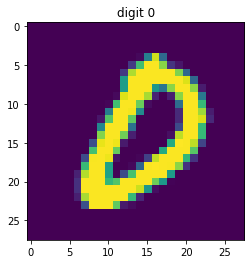

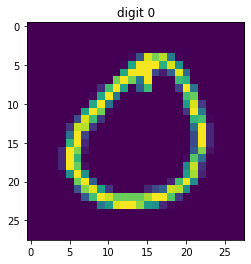

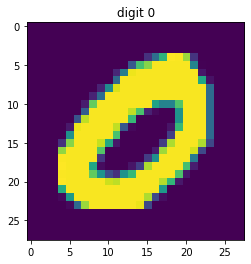

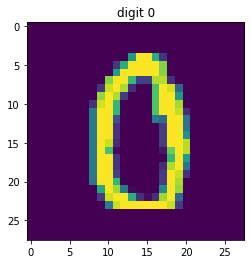

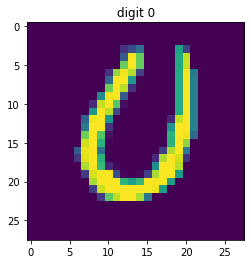

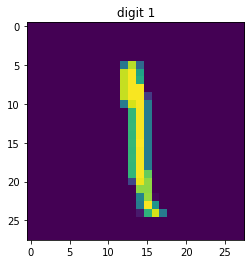

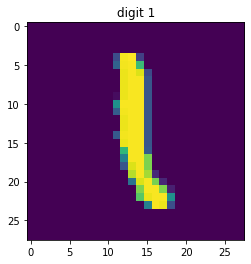

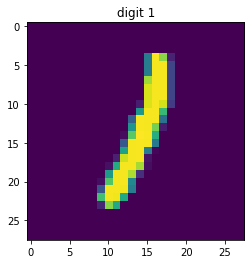

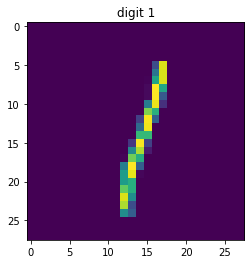

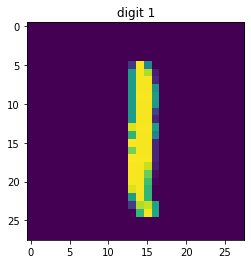

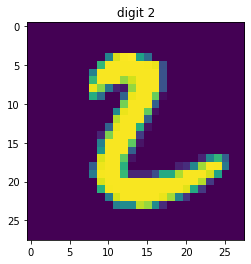

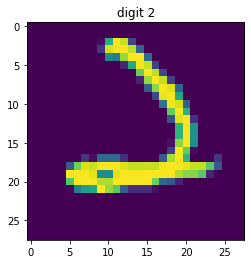

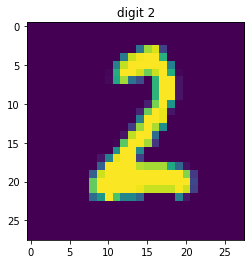

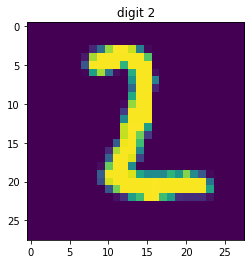

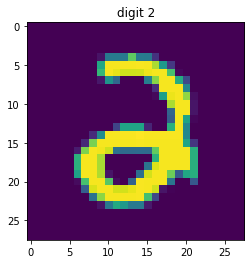

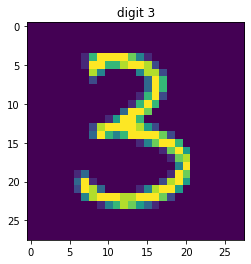

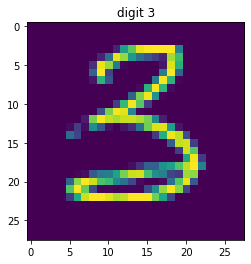

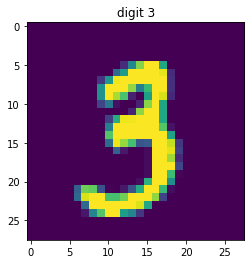

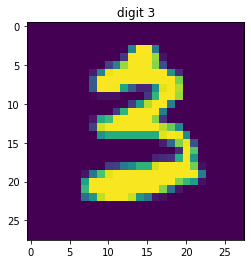

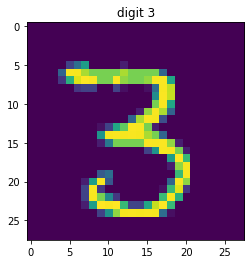

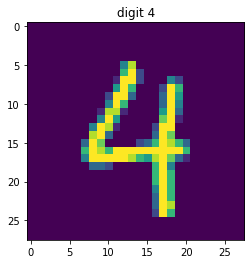

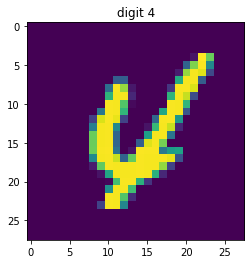

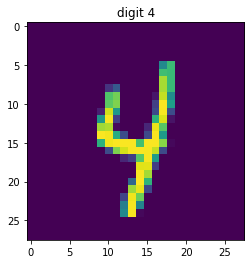

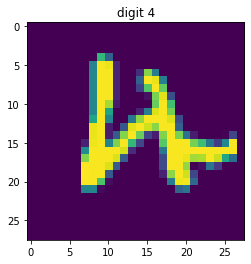

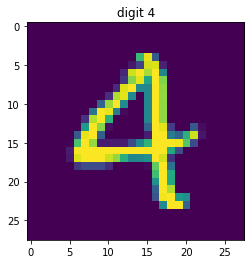

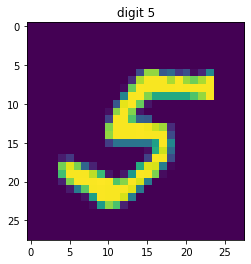

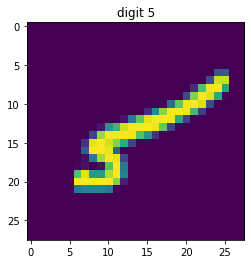

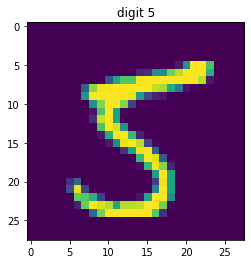

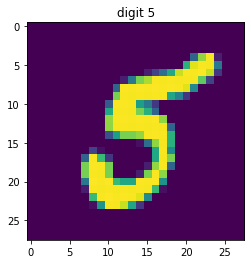

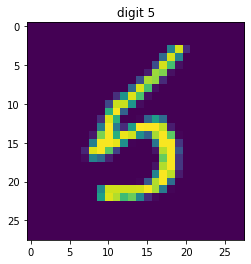

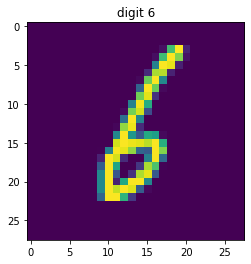

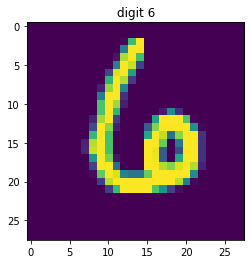

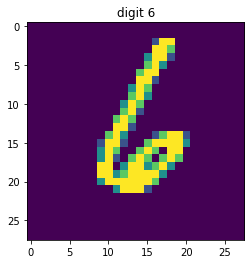

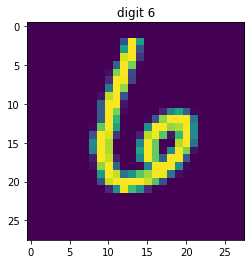

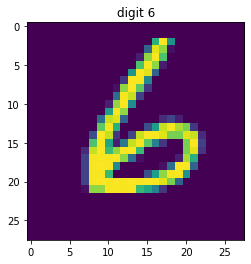

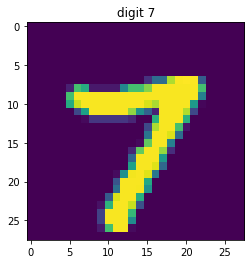

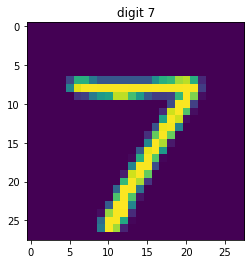

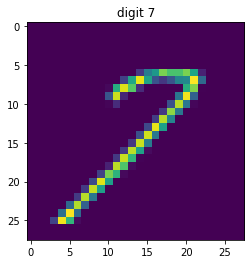

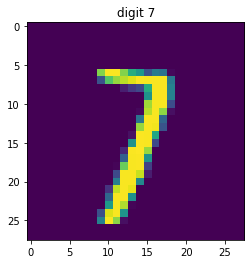

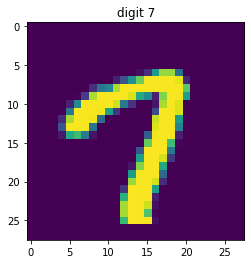

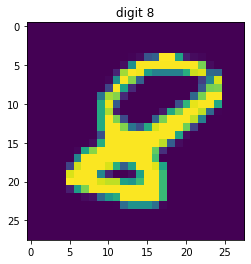

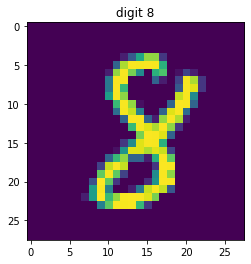

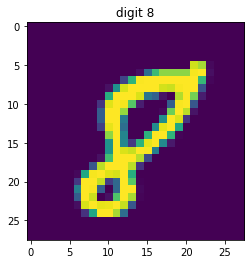

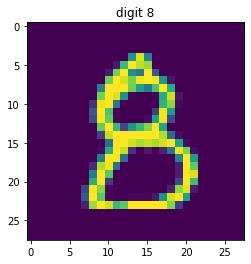

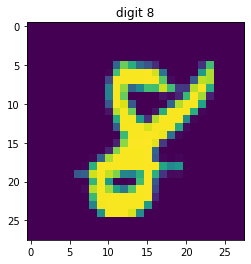

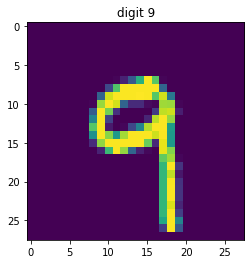

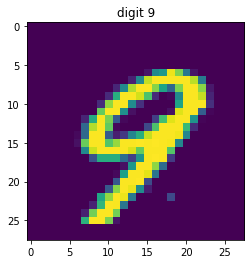

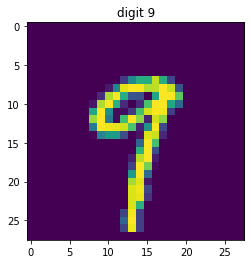

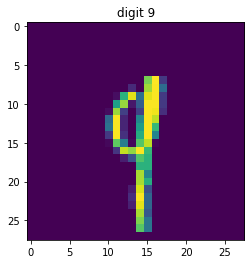

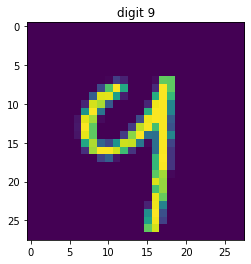

In [63]:
for digit in range(10):
    samples = orig_X[y == digit]
    random_samples = np.random.choice(range(0, len(samples)), 5)
    for i in random_samples:
        plt.imshow(samples[i])
        plt.title(f'digit {digit}')
        plt.show()

## Data Splitting

In [64]:
def split(X, y, folds=5, shuffle=True):
    assert X.shape[0] == y.shape[0]
    n = X.shape[0]
    if shuffle:
        p = np.random.permutation(n)
        X, y = X[p], y[p]
    num = n // folds
    left = n % folds
    X_folds = []
    y_folds = []
    prev = 0
    for i in range(folds):
        length = num + (left > 0)
        X_ = np.copy(X[prev: prev + length])
        y_ = np.copy(y[prev: prev + length])
        X_folds.append(X_)
        y_folds.append(y_)
        prev += length
        left -= 1
    return X_folds, y_folds

def form_train_val(X_folds, y_folds, val_fold):
    train_X_folds = [X_folds[i] for i in range(len(X_folds)) if i != val_fold]
    train_y_folds = [y_folds[i] for i in range(len(y_folds)) if i != val_fold]
    train_X = np.concatenate(train_X_folds, axis=0)
    train_y = np.concatenate(train_y_folds, axis=0)
    val_X = np.copy(X_folds[val_fold])
    val_y = np.copy(y_folds[val_fold])
    return train_X, train_y, val_X, val_y

In [65]:
X = np.array([np.ravel(r) for r in orig_X])

In [66]:
X_folds, y_folds = split(X, y)

## Model & Training

In [67]:
epsilon = 1e-6

def BCE(y_actual, y_pred):
    return -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))
    
def accuracy(y_actual, y_pred):
    return sum([y_pred[i] == y_actual[i] for i in range(len(y_actual))]) / len(y_actual)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mode(l):
    d = {0: 0}
    mode_ = 0
    for x in l:
        d[x] = (d[x] + 1) if (x in d) else 1
        if d[x] > d[mode_]:
            mode_ = x
    return mode_

In [68]:
class LogRegression_Base:
    """
    Logistic Regression Base Class with L2 Regularisation
    Utilises Binary Cross Entropy loss as loss criterion
    Uses Batch Gradient Descent for updates
    """

    def __init__(self, normalise=True, lr=0.01, reg_lambda=0.01):
        self.normalise = normalise # Gaussian normalisation
        self.lr = lr
        self.reg_lambda = reg_lambda

    def fit(self, _X, y, _X_val=None, y_val=None, epochs=2000, precision=1e-6):
        if self.normalise:
            self.mean = np.mean(_X, axis=0)
            self.std = np.std(_X, axis=0) + epsilon
            _X = (_X - self.mean) / self.std
        X = np.c_[_X, np.ones(_X.shape[0])]
        
        validation = _X_val is not None
        X_val = None
        if validation:
            if self.normalise:
                _X_val = (_X_val - self.mean) / self.std
            X_val = np.c_[_X_val, np.ones(_X_val.shape[0])]

        self.num_samples, self.dim = X.shape

        self.w = np.zeros(self.dim)
        iters = 0
        prev_step_size = np.inf
        while iters < epochs and prev_step_size > precision:
            w_ = self.w - self.lr * self.grad(X, y)
            prev_step_size = np.sum((self.w - w_) ** 2)
            self.w = w_
            iters += 1
        self.epochs_run = iters

    def loss(self, y_actual, y_pred):
        return BCE(y_actual, y_pred) + self.reg_lambda * np.sum(self.w ** 2)

    def prob(self, X):
        return sigmoid(X @ self.w)    

    def grad(self, X, y_actual):
        y_pred = self.prob(X)
        gradient = ((y_pred - y_actual) @ X) / self.num_samples + 2 * self.reg_lambda * self.w
        return gradient

    def predict(self, _X_test):
        if self.normalise:
            _X_test = (_X_test - self.mean) / self.std
        X_test = np.c_[_X_test, np.ones(_X_test.shape[0])]
        y_pred = np.array([int((self.w.T @ x) >= 0) for x in X_test])
        return y_pred
    
    def predict_prob(self, _X_test):
        if self.normalise:
            _X_test = (_X_test - self.mean) / self.std
        X_test = np.c_[_X_test, np.ones(_X_test.shape[0])]
        return self.prob(X_test)

In [69]:
class LogRegression:
    """
    Logistic regression class capable of handling muli class classification
    Uses LogRegression_Base as base class for logistic regression
    """

    def __init__(self, method, num_classes):
        self.method = method
        assert (self.method in ['Single', 'OVO', 'OVR'])
        self.num_classes = num_classes
        if self.num_classes == 2:
            self.method = 'Single'
        self.models = {}

    def fit_single(self, _X, y, _X_val, y_val, epochs):
        self.models[0] = LogRegression_Base()
        self.models[0].fit(_X, y, _X_val, y_val, epochs)

    def fit_ovr(self, _X, y, _X_val, y_val, epochs, display):
        if display:
            print('* Fitting OVR models')
        for c in range(self.num_classes):
            y_c = np.array([int(u) for u in (y == c)])
            y_val_c = np.array([int(u) for u in (y_val == c)])
            self.models[c] = LogRegression_Base()
            self.models[c].fit(_X, y_c, _X_val, y_val_c, epochs)
            if display:
                print(f'> Fitted model {c}')
                print(f'> Acc. train: {accuracy(y_c, self.models[c].predict(_X))}')
                if _X_val is not None:
                    print(f'> Acc. val: {accuracy(y_val_c, self.models[c].predict(_X_val))}')
                print()
        if display:
            print('=========')

    def fit_ovo(self, _X, y, _X_val, y_val, epochs, display):
        if display:
            print('* Fitting OVO models')
        for c1 in range(self.num_classes):
            for c2 in range(c1 + 1, self.num_classes):
                idx = (y == c1) | (y == c2)
                idx_val = (y_val == c1) | (y_val == c2)
                X_c1_c2 = _X[idx]
                X_val_c1_c2 = _X_val[idx_val]
                y_c1_c2 = np.array([int(u == c1) for u in y[idx]])
                y_val_c1_c2 = np.array([int(u == c1) for u in y_val[idx_val]])
                self.models[(c1, c2)] = LogRegression_Base()
                self.models[(c1, c2)].fit(X_c1_c2, y_c1_c2, X_val_c1_c2, y_val_c1_c2, epochs)
                if display:
                    print(f'> Fitted model {c1}, {c2}')
                    print(f'> Acc. train: {accuracy(y_c1_c2, self.models[(c1, c2)].predict(X_c1_c2))}')
                    if _X_val is not None:
                        print(f'> Acc. val: {accuracy(y_val_c1_c2, self.models[(c1, c2)].predict(X_val_c1_c2))}')
                    print()
        if display:
            print('=========')
    
    def predict_ovo(self, X):
        predictions = {}
        for c1 in range(self.num_classes):
            for c2 in range(c1 + 1, self.num_classes):
                p = self.models[(c1, c2)].predict(X)
                predictions[(c1, c2)] = [c1 if u else c2 for u in p]
        y_ = np.array(list(predictions.values()))
        y = np.array([mode(y_[:, i]) for i in range(X.shape[0])])
        return y
    
    def predict_ovr(self, X):
        prob = []
        for c in range(self.num_classes):
            prob.append(self.models[c].predict_prob(X))
        prob_ = np.array(prob)
        y = np.array([np.argmax(prob_[:, i]) for i in range(X.shape[0])])
        return y
        
    def fit(self, _X, y, _X_val=None, y_val=None, epochs=2000, display=True):
        if self.method == 'Single':
            self.fit_single(_X, y, _X_val, y_val, epochs)
        if self.method == 'OVO':
            self.fit_ovo(_X, y, _X_val, y_val, epochs, display)
        if self.method == 'OVR':
            self.fit_ovr(_X, y, _X_val, y_val, epochs, display)

    def predict(self, X):
        if self.method == 'Single':
            return self.models[0].predict(X)
        if self.method == 'OVO':
            return self.predict_ovo(X)
        if self.method == 'OVR':
            return self.predict_ovr(X)

In [70]:
ovo_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
ovo_models_path = '/content/drive/My Drive/Data Colab/ml-pg-assignment-3/Weights/3/ovo-models.sav'
ovo_models_exists = os.path.exists(ovo_models_path)
ovo_models = joblib.load(ovo_models_path) if ovo_models_exists else []
for val_fold in tqdm(range(len(X_folds))):
    t_X, t_y, v_X, v_y = form_train_val(X_folds, y_folds, val_fold)
    lr = None
    if not ovo_models_exists:
        lr = LogRegression(method='OVO', num_classes=10)
        lr.fit(t_X, t_y, v_X, v_y)
        ovo_models.append(lr)
    else:
        lr = ovo_models[val_fold]

    ovo_df['Validation fold'].append(val_fold)
    ovo_df['Train Acc.'].append(accuracy(t_y, lr.predict(t_X)))
    ovo_df['Validation Acc.'].append(accuracy(v_y, lr.predict(v_X)))
    
ovo_df = pd.DataFrame(ovo_df)
if not ovo_models_exists:
    joblib.dump(ovo_models, ovo_models_path)

100%|██████████| 5/5 [02:06<00:00, 25.26s/it]


In [71]:
ovo_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.916687,0.911667
1,1,0.915875,0.916083
2,2,0.917542,0.909167
3,3,0.916542,0.915333
4,4,0.916562,0.913417


In [72]:
ovo_classwise_train_df = {}
ovo_classwise_val_df = {}
for c in range(10):
    ovo_classwise_train_df[c] = []
    ovo_classwise_val_df[c] = []
for val_fold in tqdm(range(len(X_folds))):
    t_X, t_y, v_X, v_y = form_train_val(X_folds, y_folds, val_fold)
    model = ovo_models[val_fold]
    t_p = model.predict(t_X)
    v_p = model.predict(v_X)
    for c in range(10):
        ovo_classwise_train_df[c].append(np.mean(t_p[t_y == c] == c))
        ovo_classwise_val_df[c].append(np.mean(v_p[v_y == c] == c))
ovo_classwise_train_df = pd.DataFrame(ovo_classwise_train_df)
ovo_classwise_val_df = pd.DataFrame(ovo_classwise_val_df)

100%|██████████| 5/5 [02:05<00:00, 25.01s/it]


In [73]:
ovo_classwise_train_df

,0,1,2,3,4,5,6,7,8,9
0,0.959798,0.980933,0.881579,0.872821,0.931604,0.899816,0.958017,0.915965,0.851305,0.905621
1,0.959179,0.981381,0.883784,0.869794,0.934118,0.900676,0.957161,0.912281,0.849033,0.903442
2,0.959525,0.981441,0.886274,0.874143,0.932305,0.896283,0.956301,0.915431,0.851788,0.910680
3,0.959141,0.979951,0.884672,0.870156,0.934866,0.900874,0.955635,0.914354,0.851059,0.906316
4,0.957845,0.981537,0.888002,0.872353,0.933734,0.897856,0.959553,0.912818,0.850800,0.903293


In [74]:
ovo_classwise_val_df

,0,1,2,3,4,5,6,7,8,9
0,0.947099,0.980597,0.887179,0.859873,0.938879,0.898036,0.950764,0.906959,0.839422,0.900931
1,0.962478,0.979577,0.877414,0.874262,0.923736,0.890459,0.955954,0.917534,0.852787,0.913924
2,0.950997,0.977528,0.871219,0.867781,0.939523,0.881468,0.957663,0.915294,0.849408,0.877704
3,0.959149,0.985765,0.887188,0.876040,0.920455,0.890028,0.965577,0.908272,0.844652,0.904087
4,0.967374,0.978261,0.874062,0.854096,0.934690,0.904982,0.944492,0.908944,0.843911,0.909475


In [75]:
ovr_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
ovr_models_path = '/content/drive/My Drive/Data Colab/ml-pg-assignment-3/Weights/3/ovr-models.sav'
ovr_models_exists = os.path.exists(ovr_models_path)
ovr_models = joblib.load(ovr_models_path) if ovr_models_exists else []
for val_fold in tqdm(range(len(X_folds))):
    t_X, t_y, v_X, v_y = form_train_val(X_folds, y_folds, val_fold)
    lr = None
    if not ovr_models_exists:
        lr = LogRegression(method='OVR', num_classes=10)
        lr.fit(t_X, t_y, v_X, v_y)
        ovr_models.append(lr)
    else:
        lr = ovr_models[val_fold]

    ovr_df['Validation fold'].append(val_fold)
    ovr_df['Train Acc.'].append(accuracy(t_y, lr.predict(t_X)))
    ovr_df['Validation Acc.'].append(accuracy(v_y, lr.predict(v_X)))
    
ovr_df = pd.DataFrame(ovr_df)
if not ovr_models_exists:
    joblib.dump(ovr_models, ovr_models_path)

100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


In [76]:
ovr_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.860979,0.862250
1,1,0.861437,0.858583
2,2,0.862688,0.852833
3,3,0.861417,0.858417
4,4,0.860833,0.860333


In [77]:
ovr_classwise_train_df = {}
ovr_classwise_val_df = {}
for c in range(10):
    ovr_classwise_train_df[c] = []
    ovr_classwise_val_df[c] = []
for val_fold in tqdm(range(len(X_folds))):
    t_X, t_y, v_X, v_y = form_train_val(X_folds, y_folds, val_fold)
    model = ovr_models[val_fold]
    t_p = model.predict(t_X)
    v_p = model.predict(v_X)
    for c in range(10):
        ovr_classwise_train_df[c].append(np.mean(t_p[t_y == c] == c))
        ovr_classwise_val_df[c].append(np.mean(v_p[v_y == c] == c))
ovr_classwise_train_df = pd.DataFrame(ovr_classwise_train_df)
ovr_classwise_val_df = pd.DataFrame(ovr_classwise_val_df)

100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


In [78]:
ovr_classwise_train_df

,0,1,2,3,4,5,6,7,8,9
0,0.964008,0.972603,0.818922,0.836718,0.896012,0.743796,0.927004,0.884276,0.755028,0.785445
1,0.964203,0.972258,0.818334,0.840679,0.902032,0.744463,0.926257,0.885766,0.756113,0.778128
2,0.965035,0.973981,0.826911,0.838006,0.897815,0.749885,0.924214,0.886974,0.747483,0.788709
3,0.963142,0.971520,0.816833,0.839927,0.903576,0.748850,0.923886,0.886201,0.754547,0.780211
4,0.962529,0.973144,0.819710,0.842105,0.896848,0.743832,0.927744,0.886744,0.755390,0.775750


In [79]:
ovr_classwise_val_df

,0,1,2,3,4,5,6,7,8,9
0,0.956485,0.974627,0.825641,0.839968,0.910866,0.756782,0.919355,0.881157,0.748513,0.784081
1,0.966841,0.972283,0.818640,0.851477,0.878320,0.723498,0.925775,0.887110,0.747387,0.787342
2,0.956811,0.971108,0.803803,0.827508,0.898637,0.734713,0.923793,0.883137,0.758037,0.752080
3,0.967660,0.975801,0.817889,0.838602,0.882867,0.739049,0.929432,0.881245,0.744482,0.778982
4,0.965742,0.968841,0.819850,0.837031,0.910941,0.740775,0.913749,0.884770,0.742710,0.785110


## Using sklearn

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [81]:
ovo_sklearn_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
ovo_sklearn_models_path = '/content/drive/My Drive/Data Colab/ml-pg-assignment-3/Weights/3/ovo-sklearn-models.sav'
ovo_sklearn_models_exists = os.path.exists(ovo_sklearn_models_path)
ovo_sklearn_models = joblib.load(ovo_sklearn_models_path) if ovo_sklearn_models_exists else []
for val_fold in tqdm(range(len(X_folds))):
    t_X_, t_y, v_X_, v_y = form_train_val(X_folds, y_folds, val_fold)
    # explicit standardization
    t_mean = np.mean(t_X_, axis=0)
    t_std = np.std(t_X_, axis=0) + epsilon
    t_X = (t_X_ - t_mean) / t_std
    v_X = (v_X_ - t_mean) / t_std
    
    lr = None
    if not ovo_sklearn_models_exists:
        lr = OneVsOneClassifier(LogisticRegression(max_iter=750, random_state=7))
        lr.fit(t_X, t_y)
        ovo_sklearn_models.append(lr)
    else:
        lr = ovo_sklearn_models[val_fold]

    ovo_sklearn_df['Validation fold'].append(val_fold)
    ovo_sklearn_df['Train Acc.'].append(accuracy(t_y, lr.predict(t_X)))
    ovo_sklearn_df['Validation Acc.'].append(accuracy(v_y, lr.predict(v_X)))
    
ovo_sklearn_df = pd.DataFrame(ovo_sklearn_df)
if not ovo_sklearn_models_exists:
    joblib.dump(ovo_sklearn_models, ovo_sklearn_models_path)

100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


In [82]:
ovr_sklearn_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
ovr_sklearn_models_path = '/content/drive/My Drive/Data Colab/ml-pg-assignment-3/Weights/3/ovr-sklearn-models.sav'
ovr_sklearn_models_exists = os.path.exists(ovr_sklearn_models_path)
ovr_sklearn_models = joblib.load(ovr_sklearn_models_path) if ovr_sklearn_models_exists else []
for val_fold in tqdm(range(len(X_folds))):
    t_X_, t_y, v_X_, v_y = form_train_val(X_folds, y_folds, val_fold)
    # explicit standardization
    t_mean = np.mean(t_X_, axis=0)
    t_std = np.std(t_X_, axis=0) + epsilon
    t_X = (t_X_ - t_mean) / t_std
    v_X = (v_X_ - t_mean) / t_std
    
    lr = None
    if not ovr_sklearn_models_exists:
        lr = OneVsRestClassifier(LogisticRegression(max_iter=750, random_state=7))
        lr.fit(t_X, t_y)
        ovr_sklearn_models.append(lr)
    else:
        lr = ovr_sklearn_models[val_fold]

    ovr_sklearn_df['Validation fold'].append(val_fold)
    ovr_sklearn_df['Train Acc.'].append(accuracy(t_y, lr.predict(t_X)))
    ovr_sklearn_df['Validation Acc.'].append(accuracy(v_y, lr.predict(v_X)))
    
ovr_sklearn_df = pd.DataFrame(ovr_sklearn_df)
if not ovr_sklearn_models_exists:
    joblib.dump(ovr_sklearn_models, ovr_sklearn_models_path)

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


In [83]:
ovo_sklearn_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.980083,0.929667
1,1,0.979896,0.929667
2,2,0.980125,0.927000
3,3,0.978771,0.931167
4,4,0.980396,0.932000


In [84]:
ovr_sklearn_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.933729,0.913417
1,1,0.933208,0.915583
2,2,0.935458,0.907167
3,3,0.933417,0.912917
4,4,0.932979,0.917250


In [86]:
ovo_sklearn_classwise_train_df = {}
ovo_sklearn_classwise_val_df = {}
for c in range(10):
    ovo_sklearn_classwise_train_df[c] = []
    ovo_sklearn_classwise_val_df[c] = []
for val_fold in tqdm(range(len(X_folds))):
    t_X_, t_y, v_X_, v_y = form_train_val(X_folds, y_folds, val_fold)
    # explicit standardization
    t_mean = np.mean(t_X_, axis=0)
    t_std = np.std(t_X_, axis=0) + epsilon
    t_X = (t_X_ - t_mean) / t_std
    v_X = (v_X_ - t_mean) / t_std
    
    model = ovo_sklearn_models[val_fold]
    t_p = model.predict(t_X)
    v_p = model.predict(v_X)
    for c in range(10):
        ovo_sklearn_classwise_train_df[c].append(np.mean(t_p[t_y == c] == c))
        ovo_sklearn_classwise_val_df[c].append(np.mean(v_p[v_y == c] == c))
ovo_sklearn_classwise_train_df = pd.DataFrame(ovo_sklearn_classwise_train_df)
ovo_sklearn_classwise_val_df = pd.DataFrame(ovo_sklearn_classwise_val_df)

100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


In [90]:
ovo_sklearn_classwise_train_df

,0,1,2,3,4,5,6,7,8,9
0,0.999369,0.997964,0.976608,0.957128,0.984991,0.970588,0.997679,0.980947,0.966196,0.966653
1,0.998953,0.998138,0.977764,0.961383,0.987380,0.965027,0.997229,0.979665,0.966192,0.964316
2,0.999788,0.998544,0.979588,0.959917,0.985433,0.966957,0.997678,0.980561,0.964018,0.965031
3,0.998526,0.996815,0.979012,0.960235,0.984674,0.965271,0.997267,0.977201,0.961481,0.964421
4,0.998723,0.998508,0.980878,0.961283,0.987776,0.967950,0.997261,0.981489,0.963074,0.964548


In [91]:
ovo_sklearn_classwise_val_df

,0,1,2,3,4,5,6,7,8,9
0,0.962457,0.973881,0.917949,0.897293,0.953311,0.900842,0.955008,0.935106,0.883602,0.910246
1,0.977312,0.975201,0.903442,0.904641,0.921165,0.887809,0.963295,0.940753,0.901568,0.911392
2,0.965947,0.975120,0.894555,0.909574,0.938671,0.888053,0.959356,0.933333,0.911168,0.888519
3,0.959149,0.986477,0.909750,0.915141,0.934441,0.900280,0.956971,0.938575,0.893039,0.906589
4,0.970636,0.976087,0.921601,0.889078,0.940628,0.901292,0.951324,0.941982,0.903945,0.911168


In [87]:
ovr_sklearn_classwise_train_df = {}
ovr_sklearn_classwise_val_df = {}
for c in range(10):
    ovr_sklearn_classwise_train_df[c] = []
    ovr_sklearn_classwise_val_df[c] = []
for val_fold in tqdm(range(len(X_folds))):
    t_X_, t_y, v_X_, v_y = form_train_val(X_folds, y_folds, val_fold)
    # explicit standardization
    t_mean = np.mean(t_X_, axis=0)
    t_std = np.std(t_X_, axis=0) + epsilon
    t_X = (t_X_ - t_mean) / t_std
    v_X = (v_X_ - t_mean) / t_std
    
    model = ovr_sklearn_models[val_fold]
    t_p = model.predict(t_X)
    v_p = model.predict(v_X)
    for c in range(10):
        ovr_sklearn_classwise_train_df[c].append(np.mean(t_p[t_y == c] == c))
        ovr_sklearn_classwise_val_df[c].append(np.mean(v_p[v_y == c] == c))
ovr_sklearn_classwise_train_df = pd.DataFrame(ovr_sklearn_classwise_train_df)
ovr_sklearn_classwise_val_df = pd.DataFrame(ovr_sklearn_classwise_val_df)

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


In [88]:
ovr_sklearn_classwise_train_df

,0,1,2,3,4,5,6,7,8,9
0,0.984003,0.980933,0.917711,0.902974,0.941681,0.895450,0.966667,0.949057,0.885537,0.903314
1,0.981578,0.980823,0.919236,0.905580,0.948449,0.896246,0.963555,0.946172,0.883904,0.897145
2,0.984107,0.980167,0.920642,0.905088,0.946230,0.900872,0.966434,0.949098,0.884344,0.907310
3,0.983361,0.978640,0.917320,0.901400,0.947850,0.898114,0.965307,0.948255,0.883159,0.901684
4,0.980626,0.979299,0.919101,0.902400,0.945529,0.899470,0.967558,0.945860,0.883244,0.898678


In [89]:
ovr_sklearn_classwise_val_df

,0,1,2,3,4,5,6,7,8,9
0,0.966724,0.973881,0.892308,0.872611,0.940577,0.884004,0.950764,0.921032,0.846219,0.877223
1,0.974695,0.964989,0.883291,0.895359,0.916881,0.857774,0.957586,0.928743,0.866725,0.897890
2,0.964286,0.967095,0.876404,0.869301,0.928450,0.863594,0.947502,0.928627,0.862098,0.858569
3,0.963404,0.978648,0.893634,0.894343,0.913462,0.870457,0.956110,0.922195,0.855688,0.867389
4,0.977162,0.971739,0.893244,0.884812,0.932994,0.872694,0.946200,0.928284,0.858491,0.890863
